In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Train/val directory setup

In [2]:
!mkdir -p /content/drive/MyDrive/DeHaDo-YOLO/images/train
!mkdir -p /content/drive/MyDrive/DeHaDo-YOLO/images/val
!mkdir -p /content/drive/MyDrive/DeHaDo-YOLO/labels/train
!mkdir -p /content/drive/MyDrive/DeHaDo-YOLO/labels/val

In [2]:
import os

output_base = '/content/drive/MyDrive/DeHaDo-YOLO'

# Create train/val folders for images and labels
for split in ['train', 'val']:
    os.makedirs(f"{output_base}/images/{split}", exist_ok=True)
    os.makedirs(f"{output_base}/labels/{split}", exist_ok=True)


### JSON to YOLO format conversion

In [ ]:
import json, random, shutil
from PIL import Image

# Update these based on your dataset's folder structure
input_images = '/content/drive/MyDrive/DEHADO-AI_TRAINING_DATASET/DEHADO-AI_TRAINING_DATASET/Images'
input_jsons = '/content/drive/MyDrive/DEHADO-AI_TRAINING_DATASET/DEHADO-AI_TRAINING_DATASET/Labels'

# Class labels (21 total)
field_classes = [
    'candidatename', 'Father/husbandname', 'Dateofbirth', 'qualification',
    'maritalstatus', 'gender', 'nationality', 'bloodgroup', 'experience',
    'experience1', 'presentaddress', 'permanentaddress', 'AlternateNo',
    'contactnumber', 'languageknown', 'referencescmob1', 'referencescmob2',
    'aadhaarcard', 'pancard', 'place', 'date'
]
class_map = {name: i for i, name in enumerate(field_classes)}

# Convert bbox to YOLO format
def convert_bbox(img_w, img_h, box):
    x1, y1, x2, y2 = box
    x_center = ((x1 + x2) / 2) / img_w
    y_center = ((y1 + y2) / 2) / img_h
    width = (x2 - x1) / img_w
    height = (y2 - y1) / img_h
    return x_center, y_center, width, height

# Process one JSON file
def process_json(file, split):
    with open(os.path.join(input_jsons, file)) as f:
        data = json.load(f)

    img_file = file.replace('.json', '.jpg')  # Or .jpg if needed
    img_path = os.path.join(input_images, img_file)
    if not os.path.exists(img_path):
        print(f"Image missing: {img_file}")
        return

    img = Image.open(img_path)
    img_w, img_h = img.size

    # Copy image
    shutil.copy(img_path, os.path.join(output_base, 'images', split, img_file))

    # Create YOLO label
    label_path = os.path.join(output_base, 'labels', split, file.replace('.json', '.txt'))
    with open(label_path, 'w') as out:
        for item in data:
            name = item['Field name']
            if name not in class_map:
                continue
            class_id = class_map[name]
            bbox = convert_bbox(img_w, img_h, item['Coordinate'])
            out.write(f"{class_id} {' '.join(map(str, bbox))}\n")

# Train/Val split
all_files = [f for f in os.listdir(input_jsons) if f.endswith('.json')]
random.shuffle(all_files)
split_ratio = 0.8
split_index = int(len(all_files) * split_ratio)
train_files = all_files[:split_index]
val_files = all_files[split_index:]

for f in train_files:
    process_json(f, 'train')
for f in val_files:
    process_json(f, 'val')


### YOLO configuration YAML

In [4]:
data_yaml = """
train: /content/drive/MyDrive/DeHaDo-YOLO/images/train
val: /content/drive/MyDrive/DeHaDo-YOLO/images/val

nc: 21
names: [
  "candidatename", "Father/husbandname", "Dateofbirth", "qualification",
  "maritalstatus", "gender", "nationality", "bloodgroup", "experience",
  "experience1", "presentaddress", "permanentaddress", "AlternateNo",
  "contactnumber", "languageknown", "referencescmob1", "referencescmob2",
  "aadhaarcard", "pancard", "place", "date"
]
"""

with open('/content/drive/MyDrive/DeHaDo-YOLO/data.yaml', 'w') as f:
    f.write(data_yaml)
print("data.yaml created!")


data.yaml created!


### Training model with YOLOv8s

In [ ]:
!pip install ultralytics

In [6]:
from ultralytics import YOLO

# Load the model (you can use 'yolov8n.pt' or 'yolov8s.pt')
model = YOLO('yolov8s.pt')  # or 'yolov8n.pt' if you want faster training

# Start training
model.train(
    data='/content/drive/MyDrive/DeHaDo-YOLO/data.yaml',
    epochs=50,
    imgsz=640,
    batch=8,
    name='dehado_yolov8s',
    project='/content/drive/MyDrive/DeHaDo-YOLO/runs'
)


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


100%|██████████| 21.5M/21.5M [00:00<00:00, 121MB/s] 


Ultralytics 8.3.155 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/DeHaDo-YOLO/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=dehado_yolov8s, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=Tru

100%|██████████| 755k/755k [00:00<00:00, 23.2MB/s]

Overriding model.yaml nc=80 with nc=21

                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  2                  -1  1     29056  ultralytics.nn.modules.block.C2f             [64, 64, 1, True]             
  3                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  4                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  5                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128, 256, 3, 2]              
  6                  -1  2    788480  ultralytics.nn.modules.block.C2f             [256, 256, 2, True]           
  7                  -1  1   1180672  ultralytic

 15                  -1  1    148224  ultralytics.nn.modules.block.C2f             [384, 128, 1]                 
 16                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
 17            [-1, 12]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           
 18                  -1  1    493056  ultralytics.nn.modules.block.C2f             [384, 256, 1]                 
 19                  -1  1    590336  ultralytics.nn.modules.conv.Conv             [256, 256, 3, 2]              
 20             [-1, 9]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           
 21                  -1  1   1969152  ultralytics.nn.modules.block.C2f             [768, 512, 1]                 
 22        [15, 18, 21]  1   2124175  ultralytics.nn.modules.head.Detect           [21, [128, 256, 512]]         
Model summary: 129 layers, 11,143,727 parameters, 11,143,711 gradients, 28.7 GFLOPs

Tra

100%|██████████| 5.35M/5.35M [00:00<00:00, 91.2MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.4±0.1 ms, read: 81.9±16.4 MB/s, size: 571.2 KB)


train: Scanning /content/drive/MyDrive/DeHaDo-YOLO/labels/train... 600 images, 0 backgrounds, 0 corrupt: 100%|██████████| 600/600 [00:07<00:00, 82.37it/s] 


train: New cache created: /content/drive/MyDrive/DeHaDo-YOLO/labels/train.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 13.9±20.8 ms, read: 36.9±29.9 MB/s, size: 588.0 KB)


val: Scanning /content/drive/MyDrive/DeHaDo-YOLO/labels/val... 150 images, 0 backgrounds, 0 corrupt: 100%|██████████| 150/150 [00:01<00:00, 76.06it/s]


val: New cache created: /content/drive/MyDrive/DeHaDo-YOLO/labels/val.cache
Plotting labels to /content/drive/MyDrive/DeHaDo-YOLO/runs/dehado_yolov8s/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.0004, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to /content/drive/MyDrive/DeHaDo-YOLO/runs/dehado_yolov8s
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      2.07G      1.985      3.621      1.438        270        640: 100%|██████████| 75/75 [00:38<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.53it/s]

                   all        150       2997       0.65      0.716      0.744      0.538



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      2.23G     0.9878       1.18     0.9601        265        640: 100%|██████████| 75/75 [00:36<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.12it/s]


                   all        150       2997      0.896      0.929      0.967      0.763

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      2.27G     0.8517     0.8093     0.9313        350        640: 100%|██████████| 75/75 [00:37<00:00,  2.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.11it/s]

                   all        150       2997      0.966      0.978      0.989      0.813



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50       2.3G     0.7822     0.6822     0.9118        274        640: 100%|██████████| 75/75 [00:36<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.16it/s]

                   all        150       2997      0.978      0.985       0.99      0.833



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      2.34G     0.7473     0.6076     0.8986        269        640: 100%|██████████| 75/75 [00:36<00:00,  2.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.27it/s]

                   all        150       2997      0.986      0.988      0.992      0.845



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      2.38G     0.7058     0.5708     0.8902        307        640: 100%|██████████| 75/75 [00:37<00:00,  2.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.14it/s]

                   all        150       2997       0.98      0.992      0.991       0.85



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      2.41G     0.6748     0.5408     0.8821        278        640: 100%|██████████| 75/75 [00:37<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.20it/s]

                   all        150       2997      0.985      0.993      0.992       0.86



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      2.53G     0.6744     0.5177     0.8808        286        640: 100%|██████████| 75/75 [00:37<00:00,  2.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.06it/s]


                   all        150       2997      0.988      0.993      0.992       0.87

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      2.57G     0.6479     0.4957     0.8762        264        640: 100%|██████████| 75/75 [00:36<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.91it/s]


                   all        150       2997      0.986      0.989      0.991      0.852

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      2.68G      0.618     0.4711     0.8655        263        640: 100%|██████████| 75/75 [00:34<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.95it/s]


                   all        150       2997      0.984       0.99      0.991      0.835

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      2.72G     0.6252     0.4712     0.8703        235        640: 100%|██████████| 75/75 [00:35<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.24it/s]


                   all        150       2997       0.99      0.993      0.992      0.875

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      2.76G     0.6185      0.459      0.865        187        640: 100%|██████████| 75/75 [00:35<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.24it/s]

                   all        150       2997       0.99      0.993      0.993      0.878



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      2.88G     0.6162     0.4556     0.8618        348        640: 100%|██████████| 75/75 [00:35<00:00,  2.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.27it/s]


                   all        150       2997      0.986      0.993      0.992      0.841

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      2.91G     0.5982     0.4457     0.8647        302        640: 100%|██████████| 75/75 [00:36<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.92it/s]

                   all        150       2997      0.986      0.995      0.993      0.895



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      2.95G     0.5741      0.426     0.8572        184        640: 100%|██████████| 75/75 [00:37<00:00,  2.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.53it/s]


                   all        150       2997      0.989      0.992      0.992      0.894

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      3.07G     0.5853     0.4294     0.8577        257        640: 100%|██████████| 75/75 [00:35<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.67it/s]

                   all        150       2997      0.986      0.993      0.992      0.871



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50       3.1G     0.5865     0.4264     0.8556        289        640: 100%|██████████| 75/75 [00:34<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.70it/s]

                   all        150       2997       0.99      0.995      0.992      0.896



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      3.14G     0.5686     0.4165     0.8536        190        640: 100%|██████████| 75/75 [00:35<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.69it/s]

                   all        150       2997      0.989      0.993      0.993       0.88



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      3.26G     0.5696     0.4114     0.8527        314        640: 100%|██████████| 75/75 [00:35<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.73it/s]

                   all        150       2997       0.99      0.995      0.993      0.895



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      3.29G     0.5669     0.4075     0.8515        214        640: 100%|██████████| 75/75 [00:34<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.63it/s]

                   all        150       2997      0.989      0.995      0.993      0.887



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      3.33G     0.5568     0.3973     0.8498        304        640: 100%|██████████| 75/75 [00:34<00:00,  2.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.67it/s]

                   all        150       2997      0.989      0.992      0.993       0.89



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      3.45G     0.5528     0.3926     0.8483        241        640: 100%|██████████| 75/75 [00:33<00:00,  2.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.76it/s]

                   all        150       2997       0.99      0.994      0.993      0.887



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      3.48G      0.545     0.3919     0.8489        327        640: 100%|██████████| 75/75 [00:34<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.98it/s]

                   all        150       2997       0.99      0.995      0.993      0.904



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      3.52G     0.5491     0.3966     0.8495        317        640: 100%|██████████| 75/75 [00:37<00:00,  1.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.78it/s]

                   all        150       2997       0.99      0.994      0.993       0.91



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      3.64G     0.5355     0.3846     0.8483        286        640: 100%|██████████| 75/75 [00:37<00:00,  2.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.70it/s]

                   all        150       2997       0.99      0.993      0.993      0.895



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      3.68G      0.536     0.3789     0.8468        205        640: 100%|██████████| 75/75 [00:36<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.04it/s]

                   all        150       2997       0.99      0.995      0.994       0.91



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      3.71G     0.5316     0.3774     0.8458        251        640: 100%|██████████| 75/75 [00:34<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.79it/s]

                   all        150       2997      0.991      0.993      0.993      0.903



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      3.83G     0.5233     0.3743     0.8474        336        640: 100%|██████████| 75/75 [00:33<00:00,  2.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.72it/s]

                   all        150       2997       0.99      0.995      0.993      0.905



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      3.87G     0.5277     0.3697      0.843        197        640: 100%|██████████| 75/75 [00:36<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.81it/s]

                   all        150       2997      0.991      0.995      0.993      0.903



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50       3.9G     0.5156     0.3671     0.8438        321        640: 100%|██████████| 75/75 [00:33<00:00,  2.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.68it/s]

                   all        150       2997      0.991      0.994      0.993      0.915



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      4.02G     0.5199     0.3636     0.8447        334        640: 100%|██████████| 75/75 [00:35<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.81it/s]

                   all        150       2997      0.991      0.994      0.993      0.914



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      4.05G     0.5234      0.368     0.8454        326        640: 100%|██████████| 75/75 [00:32<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.23it/s]


                   all        150       2997      0.992      0.995      0.993      0.913

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      4.09G     0.5196     0.3668     0.8405        292        640: 100%|██████████| 75/75 [00:34<00:00,  2.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.22it/s]

                   all        150       2997      0.992      0.994      0.993      0.893



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      4.21G     0.5069      0.358     0.8409        255        640: 100%|██████████| 75/75 [00:37<00:00,  2.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.32it/s]

                   all        150       2997      0.991      0.996      0.994      0.916



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      4.25G     0.5098     0.3562     0.8385        350        640: 100%|██████████| 75/75 [00:39<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.05it/s]


                   all        150       2997      0.991      0.996      0.993      0.913

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      4.37G     0.5145     0.3568     0.8401        289        640: 100%|██████████| 75/75 [00:35<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.01it/s]


                   all        150       2997      0.991      0.995      0.993      0.915

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50       4.4G     0.5021     0.3505     0.8368        273        640: 100%|██████████| 75/75 [00:35<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.16it/s]


                   all        150       2997      0.991      0.995      0.994      0.918

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      4.44G      0.501      0.348     0.8403        268        640: 100%|██████████| 75/75 [00:36<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.72it/s]


                   all        150       2997      0.991      0.995      0.994      0.922

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      4.55G      0.496     0.3508     0.8413        257        640: 100%|██████████| 75/75 [00:36<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.65it/s]

                   all        150       2997      0.991      0.995      0.994      0.919



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      4.59G      0.497     0.3451     0.8388        300        640: 100%|██████████| 75/75 [00:34<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.53it/s]


                   all        150       2997      0.991      0.995      0.993      0.925
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      4.63G     0.4496     0.3242     0.8227        162        640: 100%|██████████| 75/75 [00:38<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.21it/s]

                   all        150       2997      0.992      0.995      0.994      0.917



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      4.66G     0.4555     0.3223     0.8213        155        640: 100%|██████████| 75/75 [00:35<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.12it/s]

                   all        150       2997      0.991      0.995      0.993      0.906



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50       4.7G     0.4491     0.3183     0.8214        160        640: 100%|██████████| 75/75 [00:36<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.14it/s]

                   all        150       2997      0.992      0.996      0.993      0.921



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      4.73G     0.4406     0.3129     0.8188        160        640: 100%|██████████| 75/75 [00:34<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.88it/s]


                   all        150       2997      0.991      0.995      0.994      0.918

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      4.77G     0.4351     0.3086     0.8186        158        640: 100%|██████████| 75/75 [00:33<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.54it/s]


                   all        150       2997      0.992      0.995      0.993      0.924

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      4.81G     0.4368     0.3107     0.8179        159        640: 100%|██████████| 75/75 [00:35<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.59it/s]

                   all        150       2997      0.992      0.996      0.993      0.926



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      4.84G     0.4305     0.3031     0.8187        156        640: 100%|██████████| 75/75 [00:36<00:00,  2.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.78it/s]

                   all        150       2997      0.992      0.995      0.993      0.926



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50       4.9G     0.4301     0.3045     0.8177        155        640: 100%|██████████| 75/75 [00:37<00:00,  1.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.25it/s]

                   all        150       2997      0.991      0.995      0.993      0.929



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      4.99G     0.4245     0.3013     0.8165        161        640: 100%|██████████| 75/75 [00:37<00:00,  2.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.09it/s]

                   all        150       2997      0.991      0.995      0.993      0.927



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      5.14G     0.4257     0.3019     0.8167        154        640: 100%|██████████| 75/75 [00:35<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.33it/s]

                   all        150       2997      0.991      0.996      0.993      0.929



50 epochs completed in 0.590 hours.
Optimizer stripped from /content/drive/MyDrive/DeHaDo-YOLO/runs/dehado_yolov8s/weights/last.pt, 22.5MB
Optimizer stripped from /content/drive/MyDrive/DeHaDo-YOLO/runs/dehado_yolov8s/weights/best.pt, 22.5MB

Validating /content/drive/MyDrive/DeHaDo-YOLO/runs/dehado_yolov8s/weights/best.pt...
Ultralytics 8.3.155 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 11,133,711 parameters, 0 gradients, 28.5 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:09<00:00,  1.02it/s]


                   all        150       2997      0.991      0.996      0.993       0.93
         candidatename        149        149      0.992          1      0.995      0.956
    Father/husbandname        150        150      0.992      0.993       0.99      0.936
           Dateofbirth        150        150          1      0.996      0.995      0.964
         qualification        150        150      0.991      0.993      0.994      0.927
         maritalstatus        150        150      0.999          1      0.995      0.951
                gender        147        147      0.993      0.982       0.99      0.918
           nationality        146        146      0.992          1      0.993      0.939
            bloodgroup        147        147      0.993          1      0.995       0.87
            experience        150        150          1          1      0.995      0.933
           experience1        150        150      0.999          1      0.995      0.942
        presentaddres

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7f247e8d7650>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0

### Export predictions to JSON

In [ ]:
from ultralytics import YOLO
import os
import json

# Load YOLO model
model = YOLO('/content/drive/MyDrive/DeHaDo-YOLO/runs/dehado_yolov8s/weights/best.pt')

# Image directory and output directory
image_dir = '/content/drive/MyDrive/DeHaDo-AI_TEST_DATA/IMAGES'
output_dir = '/content/drive/MyDrive/predictions_test'
os.makedirs(output_dir, exist_ok=True)

# Define desired output order
FIELD_ORDER = [
    "candidatename", "Father/husbandname", "Dateofbirth", "qualification", "maritalstatus",
    "gender", "nationality", "bloodgroup", "experience", "experience1", "presentaddress",
    "permanentaddress", "AlternateNo", "contactnumber", "languageknown", "referencescmob1",
    "referencescmob2", "aadhaarcard","pancard", "place", "date"
]

class_names = model.names

# Loop through all images
for img_file in os.listdir(image_dir):
    if not img_file.lower().endswith(('.jpg', '.jpeg', '.png')):
        continue

    img_path = os.path.join(image_dir, img_file)
    image_name = os.path.splitext(img_file)[0]
    results = model(img_path)[0]

    # Store detections temporarily
    detected_fields = {}

    for box in results.boxes:
        cls_id = int(box.cls[0])
        class_name = class_names[cls_id]
        coords = [int(x) for x in box.xyxy[0].tolist()]
        detected_fields[class_name] = coords

    # Prepare ordered output
    ordered_output = []
    for field in FIELD_ORDER:
        if field in detected_fields:
            ordered_output.append({
                "Field name": field,
                "Coordinate": detected_fields[field]
            })

    # Save JSON
    json_path = os.path.join(output_dir, f"{image_name}_predicted.json")
    with open(json_path, "w") as f:
        json.dump(ordered_output, f, indent=2)

print("All ordered JSONs saved to:", output_dir)


### Prediction on test


image 1/1 /content/drive/MyDrive/DeHaDo-AI_TEST_DATA/IMAGES/MIT_1503.jpg: 640x480 1 candidatename, 1 Father/husbandname, 1 Dateofbirth, 1 qualification, 1 maritalstatus, 1 gender, 1 nationality, 1 bloodgroup, 1 experience, 1 experience1, 1 presentaddress, 1 permanentaddress, 1 AlternateNo, 1 contactnumber, 1 languageknown, 1 referencescmob1, 1 referencescmob2, 1 aadhaarcard, 1 place, 1 date, 487.8ms
Speed: 5.6ms preprocess, 487.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 480)
Results saved to runs/detect/predict


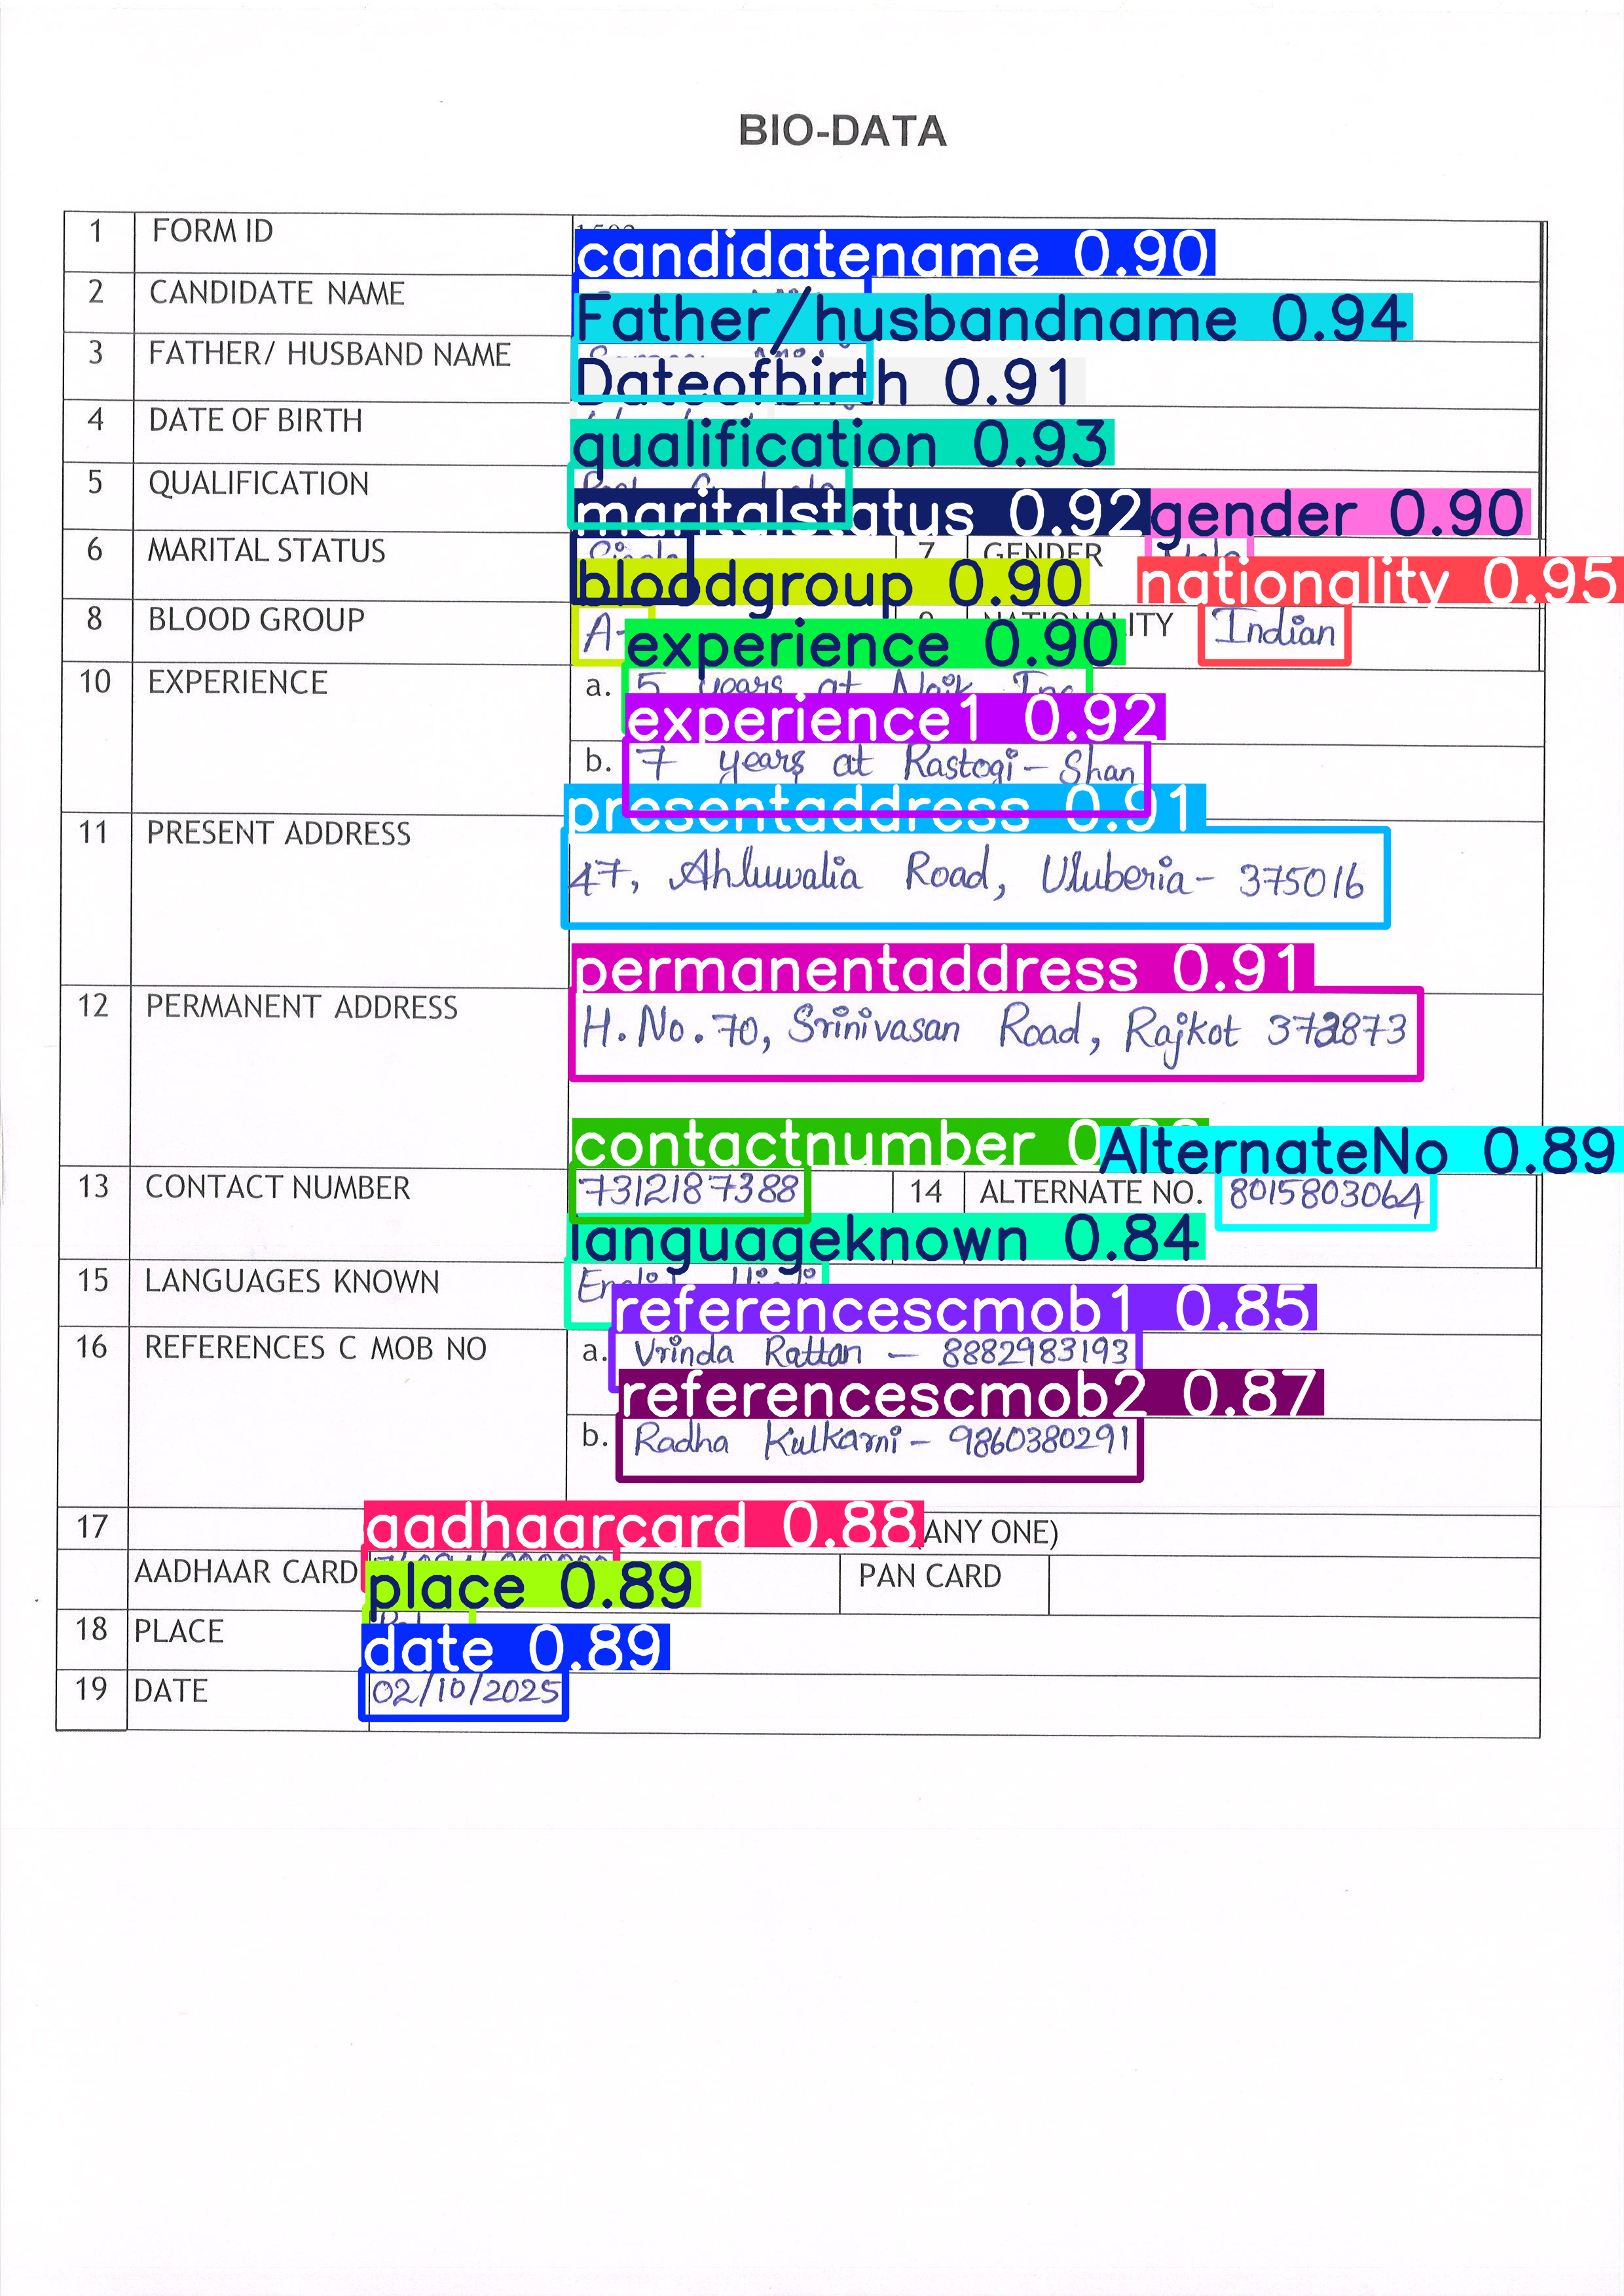

In [8]:
from ultralytics import YOLO

# Load the trained YOLOv8 model (update path to your best.pt)
model = YOLO('/content/drive/MyDrive/DeHaDo-YOLO/runs/dehado_yolov8s/weights/best.pt')

# Predict on a single image
results = model.predict(source='/content/drive/MyDrive/DeHaDo-AI_TEST_DATA/IMAGES/MIT_1503.jpg', save=True, conf=0.25)

# Visualize the image with predicted boxes (inline in notebook)
results[0].show()
